** Spoiler: ** This solution can get 99% in the public leaderboard, so continue reading will deprive you of pretty much all the fun of solving the puzzle yourselves.

## General idea

This is not hard data. Using default parametered RBF kernel SVM will get 92%. The discussions in the forum are mainly about how to use feature engineering to enhance SVM. Using well tuned PCA will get 94%. One tutorial used Sparse Filtering and got 96%. I'm never a big fan of neural networks or deep learning and found out that modeling the data is the key. By finding out the parameters of the distribution, we are able to transform each record into the latent variable in the distribution. Using the latent variables alone as features significantly outperforms the original data or PCA components.

The treatment consists of three steps. Firstly, I used run whitened PCA on the orignial data. From there I plotted KDE(Kernal Density Estimation) figure for each of the PCA components. By observing the patterns in the plots, GMM(Gaussian Mixture Model) is one of the plausible distribution. The second step is therefore fitting GMM on the data. With the trained GMM, we can get for each record the belongingness to each GMM components. Lastly, we use the belongingness as features and feed them to SVM.

In this case, hyper parameter tunning makes a huge difference. The key parameters are PCA's components number, PCA's whittening or not, GMM's components number and GMM's covariance type.

Another tip is to include the testing data in the unsupervised learning phases(PCA and GMM). Since there are 9000 testing data and only 1000 training data, it makes sense to take advantage of the testing set. This tip improved my score from 98% to 99%.

## First thing first: loading data

In [6]:
import numpy as np
import pandas as pd
from sklearn.decomposition.pca import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.mixture import GMM
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt

X_test = pd.read_csv('test.csv', header=None).as_matrix()
y = pd.read_csv('trainLabels.csv', header=None)[0].as_matrix()
X = pd.read_csv('train.csv', header=None).as_matrix()

The training data is 1000 by 40 and the testing data is 9000 by 40. Let's reduce the demenstion to 2 so that the training data can be plotted. As we can see from the plot below, the 2D graph is not much separable.

(490, 2)


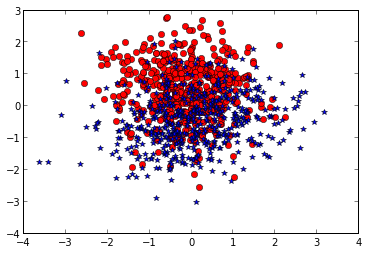

In [11]:
pca2 = PCA(n_components=2, whiten=True)
pca2.fit(np.r_[X, X_test])
X_pca = pca2.transform(X)
i0 = np.argwhere(y == 0)[:, 0]
i1 = np.argwhere(y == 1)[:, 0]
X0 = X_pca[i0, :]
X1 = X_pca[i1, :]
plt.plot(X0[:, 0], X0[:, 1], 'ro')
plt.plot(X1[:, 0], X1[:, 1], 'b*')

##PCA
Since we have no idea about the meaning of any features, we loss no information running PCA on the data. Many have found out that using the first 12 PCA components as feature will improve SVM accuracy from 92% to 94%. It seem that the last three components are nosie and should be discarded. 

In [13]:
pca = PCA(whiten=True)
X_all = pca.fit_transform(np.r_[X, X_test])
print pca.explained_variance_ratio_

[  2.61338893e-01   2.03953972e-01   7.91104009e-02   4.81480076e-02
   4.54167442e-02   4.42563499e-02   4.04285747e-02   3.03524876e-02
   2.35202947e-02   1.92164610e-02   1.61483800e-02   1.25565492e-02
   7.65669101e-03   7.59267345e-03   7.57067587e-03   7.45196972e-03
   7.39437803e-03   7.33602203e-03   7.32154020e-03   7.26446366e-03
   7.24687802e-03   7.13785979e-03   7.08554112e-03   7.05759361e-03
   7.01144882e-03   6.98357997e-03   6.90865448e-03   6.88494883e-03
   6.84557325e-03   6.83367011e-03   6.74339150e-03   6.70112785e-03
   6.63533428e-03   6.57374179e-03   6.49188079e-03   6.46379503e-03
   6.35945185e-03   2.13086486e-31   3.58428641e-32   1.30173625e-32]


##KDE plots and QQ plots

The next sensible thing to do is the see what the distributions of each PCA components look like. We can plot histograms, but KDE with Gaussian kernal works better here. To save you some time, I only draw 4 of them. In fact, components 1-37 are all similar and the last three noise components are different.

In [20]:
def kde_plot(x):
        from scipy.stats.kde import gaussian_kde
        kde = gaussian_kde(x)
        positions = np.linspace(x.min(), x.max())
        smoothed = kde(positions)
        plt.plot(positions, smoothed)

def qq_plot(x):
    from scipy.stats import probplot
    probplot(x, dist='norm', plot=plt)
        

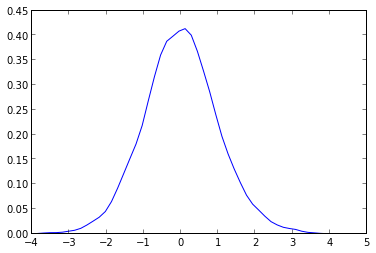

In [15]:
kde_plot(X_all[:, 0])

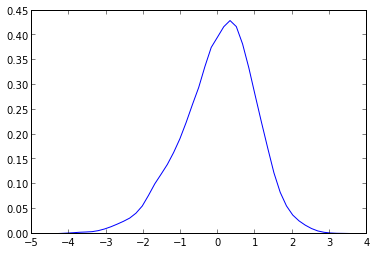

In [17]:
kde_plot(X_all[:, 2])


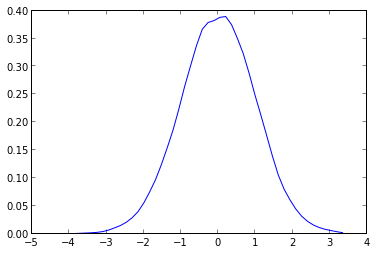

In [18]:
kde_plot(X_all[:, 30])


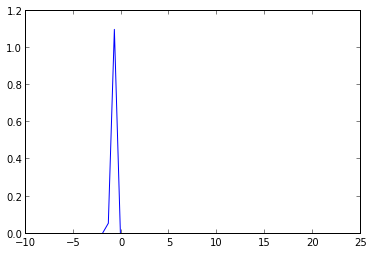

In [19]:
kde_plot(X_all[:, 38])


So are they Gaussian? I tried to model the data using multi-variant Gaussian but didn't get better result than simple SVM. Let's see the QQ plot assuming the data is from Gaussian distribution.

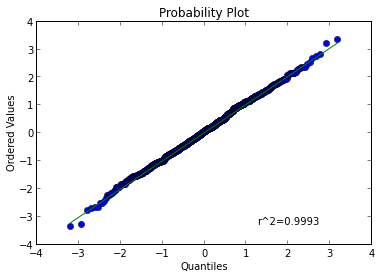

In [22]:
qq_plot(X[:,0])

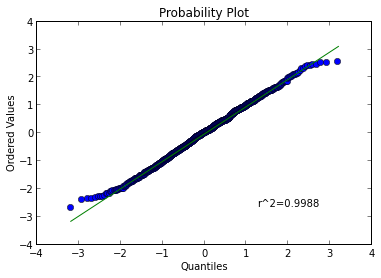

In [23]:
qq_plot(X[:,2])

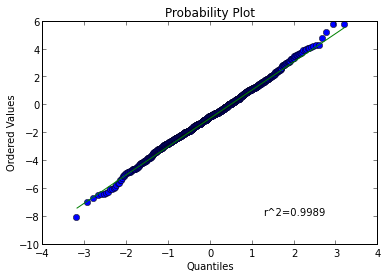

In [24]:
qq_plot(X[:,38])

To save you the time, all components including the noises, have one common pattern in the QQ plots: the middle range fits well with Gaussian but the extreme quantiles drift away. One plausible distribution that fit both the KDE plots and QQ plots is GMM. Unlike multi-variant Gaussian, data from GMM have one sample specific parameter that dipict the belongingness of that sample to each of the GMM components. This latent vector of belongingness is more of merit than the PCA components since it determines the value of the components under the GMM assumption.

The idea is to use the belongingness alone as features to feed to SVM. There will be lots of grid search to get optimal numboer of PCA components, GMM components and GMM covarance type. The idea is implemented in below code. You need to inherite from BaseEstimator in order to work with other sklearn facility like GridSearchCV.

In [28]:
class PcaGmm(BaseEstimator):
    def __init__(self, X_all,
                 pca_components = 12, gmm_components = 4,
                 covariance_type = "full", min_covar = 0.1,
                 gamma = 0, C = 1.0):

        self.pca_components = pca_components
        self.gmm_components = gmm_components
        self.covariance_type = covariance_type
        self.min_covar = min_covar
        self.gamma = gamma
        self.C = C
        self.X_all = X_all
        X_all = X_all[:, :pca_components]
        self.gmm = GMM(n_components = gmm_components,
                       covariance_type = covariance_type,
                       min_covar = min_covar)
        self.gmm.fit(X_all)

    def fit(self, X, y):
        X = X[:, :self.pca_components]
        X = self.gmm.predict_proba(X)
        self.svm = SVC(C = self.C, gamma = self.gamma)
        self.svm.fit(X, y)

    def predict(self, X):
        X = X[:, :self.pca_components]
        return self.svm.predict(self.gmm.predict_proba(X))

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def transform(self, X, y = None):
        X = X[:, :self.pca_components]
        return self.gmm.predict_proba(X)

    def __str__(self):
        return "PCA(%d)-GMM(%d, %s, %f)-SVM(C=%f, gamma=%f)" % (self.pca_components, self.gmm_components,
                                                                self.covariance_type, self.min_covar,
                                                                self.C, self.gamma)


Careful grid search will find the key hyper parameters as below:

* PCA components no. is 12
* GMM components no. is 4
* GMM covarance type is 'full'

My model got 0.99143 in the public leaderboard. Let's see the PCA and GMM generated feature compare to the original one.

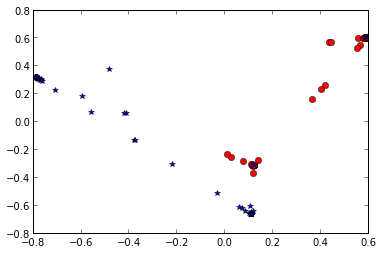

In [31]:
clf = PcaGmm(X_all,
            12, 4, 'full', 0, gamma = .6, C = 0.3)
X_t = clf.transform(pca.transform(X))
X0 = X_t[i0, :]
X1 = X_t[i1, :]
pca2 = PCA(n_components=2)
pca2.fit(np.r_[X0, X1])
X0 = pca2.transform(X0)
X1 = pca2.transform(X1)
plt.plot(X0[:, 0], X0[:, 1], 'ro')
plt.plot(X1[:, 0], X1[:, 1], 'b*')

Looks much better, huh?

## Acknowlegement

I can't figure it out without help from [Peter Williams](http://www.linkedin.com/profile/view?id=57878071&authType=OUT_OF_NETWORK&authToken=-mnJ&locale=en_US&trk=tyah2&trkInfo=tarId%3A1402026200787%2Ctas%3Apeter%20wi%2Cidx%3A1-1-1). Peter was on top of the leaderboard when I got there. He patiently answered lots of my silly questions via Email. We have a [thread](http://www.kaggle.com/c/data-science-london-scikit-learn/forums/t/8104/anyone-in-the-99-league-care-to-share-the-solution) at Kaggle forum, thank all for participating the discussion and bearing with my unfamiliar with statistical modeling. 